<a href="https://colab.research.google.com/github/rithikafjohnson/Prompt-Stealing-Attack-Model/blob/main/PromptStealingonAssessPromptDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preprocessing



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2LMHeadModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


# Load the CSV file
file_path = 'prompt-content_dataset_new.csv'
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    exit()
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
    exit()
except pd.errors.ParserError:
    print("Error: There was an error parsing the file. Ensure it's a valid CSV format.")
    exit()

# Filter rows with non-empty 'Assessment' column
df = df[df['Assessment Content'].notna()]
if df.empty:
    print("No valid 'Assessment' data found.")
    exit()

Data loaded successfully.


In [ ]:
# Shuffle the DataFrame
df = df.sample(frac=1)

# Reset the index
df.reset_index(drop=True, inplace=True)
# df_test = df[200:]
# df = df[:200]

print(len(df))
# print(len(df_test))
# print(df)

250


Modifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your dataset (make sure train_df and test_df are already defined before running this code)


# Preprocessing
df["Input"] = df["Assessment Content"]

# Store the original Category and Topic names in separate columns to preserve them
df["Original_Category"] = df["Question Type"]
df["Original_Topic"] = df["Topic"]

# Label encoding for categories and topics, storing the encoded values in new columns
category_encoder = LabelEncoder()
topic_encoder = LabelEncoder()

df["Encoded_Category"] = category_encoder.fit_transform(df["Question Type"])
df["Encoded_Topic"] = topic_encoder.fit_transform(df["Topic"])

# Create the mapping dictionaries to decode back during evaluation
category_mapping = dict(zip(category_encoder.classes_, range(len(category_encoder.classes_))))
topic_mapping = dict(zip(topic_encoder.classes_, range(len(topic_encoder.classes_))))



In [ ]:
# Dataset and DataLoader
class AssessmentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        inputs = self.tokenizer(
            row["Input"],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "category_label": torch.tensor(row["Encoded_Category"]),
            # "topic_label": torch.tensor(row["Encoded_Topic"])
        }

# Load BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 128

# Split Data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True)
train_dataset = AssessmentDataset(train_df, bert_tokenizer, max_len)
val_dataset = AssessmentDataset(val_df, bert_tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Model Definition
class BertClassifier(nn.Module):
    def __init__(self, num_categories):
        super(BertClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        self.fc_category = nn.Linear(self.bert_model.config.hidden_size, num_categories)
        # self.fc_topic = nn.Linear(self.bert_model.config.hidden_size, num_topics)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden_state = outputs.pooler_output  # [CLS] token representation
        category_logits = self.fc_category(hidden_state)
        # topic_logits = self.fc_topic(hidden_state)
        return category_logits

# Initialize Model, Optimizer, and Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_categories = len(category_encoder.classes_)
# num_topics = len(topic_encoder.classes_)
model_bert = BertClassifier(num_categories).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=2e-5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# training by optimizing category loss only **use it only if there's not an already trained model**

# Training Function
def train_model(model, train_loader, optimizer, criterion, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        # total_loss_category = 0
        # total_loss_topic = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            category_labels = batch["category_label"].to(device)
            # topic_labels = batch["topic_label"].to(device)

            optimizer.zero_grad()
            category_logits = model_bert(input_ids, attention_mask)
            loss_category = criterion(category_logits, category_labels)
            # loss_topic = criterion(topic_logits, topic_labels)
            loss = loss_category
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # total_loss_category += loss_category.item()
            # total_loss_topic += loss_topic.item()

        avg_loss = total_loss / len(train_loader)
        # avg_loss_category = total_loss_category / len(train_loader)
        # avg_loss_topic = total_loss_topic / len(train_loader)
        # print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Category Loss: {avg_loss_category:.4f}, Topic Loss: {avg_loss_topic:.4f}")
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    # Save the trained model
    torch.save(model_bert.state_dict(), "bert_classifier_category.pth")
    print("Model saved successfully.")

# Train the Model
train_model(model_bert, train_loader, optimizer, criterion, epochs=100)

Epoch 1/100, Loss: 1.6389
Epoch 2/100, Loss: 1.5977
Epoch 3/100, Loss: 1.5675
Epoch 4/100, Loss: 1.4843
Epoch 5/100, Loss: 1.3761
Epoch 6/100, Loss: 1.2549
Epoch 7/100, Loss: 0.9949
Epoch 8/100, Loss: 0.7841
Epoch 9/100, Loss: 0.6232
Epoch 10/100, Loss: 0.4156
Epoch 11/100, Loss: 0.2556
Epoch 12/100, Loss: 0.1575
Epoch 13/100, Loss: 0.1008
Epoch 14/100, Loss: 0.0679
Epoch 15/100, Loss: 0.0516
Epoch 16/100, Loss: 0.0497
Epoch 17/100, Loss: 0.0377
Epoch 18/100, Loss: 0.0287
Epoch 19/100, Loss: 0.0233
Epoch 20/100, Loss: 0.0201
Epoch 21/100, Loss: 0.0164
Epoch 22/100, Loss: 0.0145
Epoch 23/100, Loss: 0.0132
Epoch 24/100, Loss: 0.0120
Epoch 25/100, Loss: 0.0111
Epoch 26/100, Loss: 0.0101
Epoch 27/100, Loss: 0.0090
Epoch 28/100, Loss: 0.0088
Epoch 29/100, Loss: 0.0080
Epoch 30/100, Loss: 0.0074
Epoch 31/100, Loss: 0.0070
Epoch 32/100, Loss: 0.0065
Epoch 33/100, Loss: 0.0061
Epoch 34/100, Loss: 0.0059
Epoch 35/100, Loss: 0.0056
Epoch 36/100, Loss: 0.0053
Epoch 37/100, Loss: 0.0050
Epoch 38/1

In [ ]:
# Evaluation Function
def evaluate_model(val_loader, category_mapping, device='cuda'):
    # Load the trained bert_model
    bert_model = BertClassifier(num_categories).to(device)
    bert_model.load_state_dict(torch.load("bert_classifier_category.pth"))
    bert_model.eval()

    predicted_categories = []
    # predicted_topics = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Get the logits from the bert_model
            category_logits = bert_model(input_ids, attention_mask)

            # Get the predicted category and topic indices
            category_predictions = torch.argmax(category_logits, dim=1).cpu().tolist()
            # topic_predictions = torch.argmax(topic_logits, dim=1).cpu().tolist()

            # Decode the numeric labels back into their original string labels using mappings
            decoded_categories = [list(category_mapping.keys())[list(category_mapping.values()).index(pred)] for pred in category_predictions]
            # decoded_topics = [list(topic_mapping.keys())[list(topic_mapping.values()).index(pred)] for pred in topic_predictions]

            # Extend the lists with decoded labels
            predicted_categories.extend(decoded_categories)
            # predicted_topics.extend(decoded_topics)

    return predicted_categories

In [ ]:
# evaluation for category predictor model
import numpy as np

# Evaluate the Model
predicted_categories = evaluate_model(val_loader, category_mapping)

# Output predictions in original names
print("Predicted Categories:", predicted_categories)

print(val_df["Original_Category"].tolist())
print(predicted_categories)

print(np.sum(predicted_categories == val_df["Original_Category"]))

<ipython-input-6-278dde581ee4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_model.load_state_dict(torch.load("bert_classifier_category.pth"))


Predicted Categories: ['True/False', 'True/False', 'Multiple Choice', 'True/False', 'Multiple Choice', 'Multiple Choice', 'Fill-in-the-blank', 'Fill-in-the-blank', 'Short Answer', 'Sentence Completion', 'Sentence Completion', 'Multiple Choice', 'Fill-in-the-blank', 'Multiple Choice', 'Fill-in-the-blank', 'True/False', 'True/False', 'Fill-in-the-blank', 'Short Answer', 'Sentence Completion', 'Fill-in-the-blank', 'Sentence Completion', 'Multiple Choice', 'Short Answer', 'True/False', 'Short Answer', 'Short Answer', 'Fill-in-the-blank', 'Fill-in-the-blank', 'Short Answer', 'Sentence Completion', 'Multiple Choice', 'Sentence Completion', 'Multiple Choice', 'Short Answer', 'Short Answer', 'Fill-in-the-blank', 'Sentence Completion', 'Multiple Choice', 'Short Answer', 'Short Answer', 'Sentence Completion', 'Sentence Completion', 'Sentence Completion', 'Fill-in-the-blank', 'Multiple Choice', 'Sentence Completion', 'Sentence Completion', 'Multiple Choice', 'Multiple Choice']
['Multiple Choice',

In [ ]:
print(np.mean(predicted_categories == val_df["Original_Category"]))

0.78


In [ ]:
# training by optimizing topic loss only

# Dataset and DataLoader
class AssessmentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        inputs = self.tokenizer(
            row["Input"],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            # "category_label": torch.tensor(row["Encoded_Category"]),
            "topic_label": torch.tensor(row["Encoded_Topic"])
        }

# Load BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 128

# Split Data into training and validation sets
# train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)
# train_dataset = AssessmentDataset(train_df, bert_tokenizer, max_len)
# val_dataset = AssessmentDataset(val_df, bert_tokenizer, max_len)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8)

# Model Definition
class BertClassifier(nn.Module):
    def __init__(self, num_topics):
        super(BertClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        # self.fc_category = nn.Linear(self.bert_model.config.hidden_size, num_categories)
        self.fc_topic = nn.Linear(self.bert_model.config.hidden_size, num_topics)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden_state = outputs.pooler_output  # [CLS] token representation
        # category_logits = self.fc_category(hidden_state)
        topic_logits = self.fc_topic(hidden_state)
        return topic_logits

# Initialize Model, Optimizer, and Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_categories = len(category_encoder.classes_)
num_topics = len(topic_encoder.classes_)
model_bert = BertClassifier(num_topics).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=2e-5)

In [ ]:
# Training Function **use it only if there's not an already trained model**

def train_model(model, train_loader, optimizer, criterion, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        # total_loss_category = 0
        # total_loss_topic = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            # category_labels = batch["category_label"].to(device)
            topic_labels = batch["topic_label"].to(device)

            optimizer.zero_grad()
            topic_logits = model(input_ids, attention_mask)
            # loss_category = criterion(category_logits, category_labels)
            loss_topic = criterion(topic_logits, topic_labels)
            loss = loss_topic
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # total_loss_category += loss_category.item()
            # total_loss_topic += loss_topic.item()

        avg_loss = total_loss / len(train_loader)
        # avg_loss_category = total_loss_category / len(train_loader)
        # avg_loss_topic = total_loss_topic / len(train_loader)
        # print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Category Loss: {avg_loss_category:.4f}, Topic Loss: {avg_loss_topic:.4f}")
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), "bert_classifier_topic.pth")
    print("Model saved successfully.")

# Train the Model
train_model(model_bert, train_loader, optimizer, criterion, epochs=100)

Epoch 1/100, Loss: 3.8998
Epoch 2/100, Loss: 3.7298
Epoch 3/100, Loss: 3.4513
Epoch 4/100, Loss: 3.1776
Epoch 5/100, Loss: 2.8613
Epoch 6/100, Loss: 2.5742
Epoch 7/100, Loss: 2.2631
Epoch 8/100, Loss: 1.9893
Epoch 9/100, Loss: 1.7549
Epoch 10/100, Loss: 1.5510
Epoch 11/100, Loss: 1.3613
Epoch 12/100, Loss: 1.1938
Epoch 13/100, Loss: 1.0709
Epoch 14/100, Loss: 0.9482
Epoch 15/100, Loss: 0.8379
Epoch 16/100, Loss: 0.7462
Epoch 17/100, Loss: 0.6656
Epoch 18/100, Loss: 0.5929
Epoch 19/100, Loss: 0.5348
Epoch 20/100, Loss: 0.4806
Epoch 21/100, Loss: 0.4372
Epoch 22/100, Loss: 0.3910
Epoch 23/100, Loss: 0.3616
Epoch 24/100, Loss: 0.3333
Epoch 25/100, Loss: 0.3046
Epoch 26/100, Loss: 0.2798
Epoch 27/100, Loss: 0.2574
Epoch 28/100, Loss: 0.2372
Epoch 29/100, Loss: 0.2215
Epoch 30/100, Loss: 0.2063
Epoch 31/100, Loss: 0.1934
Epoch 32/100, Loss: 0.1812
Epoch 33/100, Loss: 0.1701
Epoch 34/100, Loss: 0.1604
Epoch 35/100, Loss: 0.1514
Epoch 36/100, Loss: 0.1428
Epoch 37/100, Loss: 0.1356
Epoch 38/1

In [ ]:
# Evaluation Function
def evaluate_model(val_loader, topic_mapping, device='cuda'):
    # Load the trained bert_model
    bert_model = BertClassifier(num_topics).to(device)
    bert_model.load_state_dict(torch.load("bert_classifier_topic.pth"))
    bert_model.eval()

    # predicted_categories = []
    predicted_topics = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Get the logits from the bert_model
            topic_logits = bert_model(input_ids, attention_mask)

            # Get the predicted category and topic indices
            # category_predictions = torch.argmax(category_logits, dim=1).cpu().tolist()
            topic_predictions = torch.argmax(topic_logits, dim=1).cpu().tolist()

            # Decode the numeric labels back into their original string labels using mappings
            # decoded_categories = [list(category_mapping.keys())[list(category_mapping.values()).index(pred)] for pred in category_predictions]
            decoded_topics = [list(topic_mapping.keys())[list(topic_mapping.values()).index(pred)] for pred in topic_predictions]

            # Extend the lists with decoded labels
            # predicted_categories.extend(decoded_categories)
            predicted_topics.extend(decoded_topics)

    return predicted_topics

In [ ]:
# evaluate the topic predictor

import numpy as np

# Evaluate the Model
predicted_topics = evaluate_model(val_loader, topic_mapping)

# Output predictions in original names
# print("Predicted Categories:", predicted_categories)
print("Predicted Topics:", predicted_topics)

<ipython-input-10-0f770712d9da>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_model.load_state_dict(torch.load("bert_classifier_topic.pth"))


Predicted Topics: ['Language origins', 'Language origins', 'animal behavior', 'historical events', 'language acquisition', 'famous landmarks', 'Job market trends', 'language acquisition', 'astronomy', 'robotics', 'workplace innovation', 'robotics', 'Ancient civilizations', 'Global sporting events', 'psychology', 'Cultural highlights', 'scientific breakthroughs', 'Learning methods', 'biodiversity', 'abstract concepts', 'AI in education', 'space exploration', 'conservation', 'Ethical debates', 'medical breakthroughs', 'significant historical figures', 'cultural movements', 'famous philosophers', 'Deforestation', 'economics', 'public health issues', 'famous philosophers', 'Artificial intelligence', 'workplace innovation', 'Learning methods', 'exercise science', 'exercise science', 'renewable energy', 'biodiversity', 'astronomy', 'medical breakthroughs', 'Job market trends', 'literary analysis', 'Global sporting events', 'Artificial intelligence', 'Job market trends', 'dialects', 'economic

In [ ]:
print(val_df["Original_Topic"].tolist())
print(predicted_topics)
# print(np.sum(predicted_categories == val_df["Original_Category"]))
print(np.sum(predicted_topics == val_df["Original_Topic"]))
print(np.mean(predicted_topics == val_df["Original_Topic"]))

['Language origins', 'Language origins', 'animal behavior', 'historical events', 'language acquisition', 'famous landmarks', 'Job market trends', 'language acquisition', 'astronomy', 'robotics', 'workplace innovation', 'robotics', 'Ancient civilizations', 'Global sporting events', 'psychology', 'Cultural highlights', 'scientific breakthroughs', 'Learning methods', 'biodiversity', 'abstract concepts', 'AI in education', 'space exploration', 'conservation', 'Ethical debates', 'medical breakthroughs', 'significant historical figures', 'cultural movements', 'famous philosophers', 'Deforestation', 'economics', 'public health issues', 'famous philosophers', 'Artificial intelligence', 'workplace innovation', 'Learning methods', 'exercise science', 'exercise science', 'renewable energy', 'biodiversity', 'astronomy', 'medical breakthroughs', 'Job market trends', 'literary analysis', 'Global sporting events', 'Artificial intelligence', 'Job market trends', 'dialects', 'economics', 'world wars', 

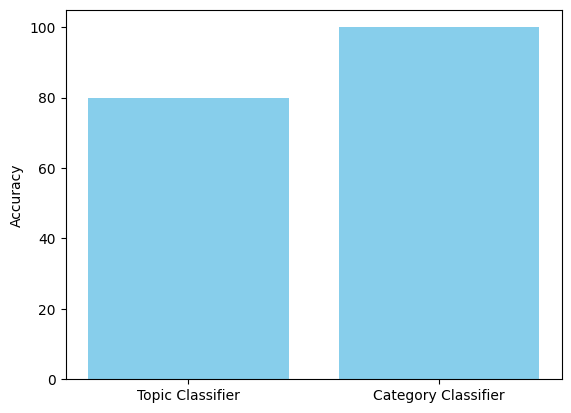

In [ ]:
import matplotlib.pyplot as plt

# Data
x_labels = ['Topic Classifier', 'Category Classifier']
y_values = [80, 100]

# Plotting
plt.bar(x_labels, y_values, color=['skyblue', 'skyblue'])

# Adding labels and title
plt.xlabel('')
plt.ylabel('Accuracy')
plt.title('')

# Display the plot
plt.show()


Combining inversion model and modifier

In [ ]:
# Construct Instructions for Train Dataset
def construct_instructions_train(contents, predicted_categories, predicted_topics, train_dataset):
    instructions = []
    for content, category, topic, original_prompt in zip(
        contents, predicted_categories, predicted_topics, train_dataset["Prompt"]
    ):
        instruction = (
            f"Instruction: generate what could be the prompt used to generate the content below.  While generating the desired prompt, ensure to include phrases that indicate the purpose of the passage, specify the topic, highlight sentence complexity, reference the evaluation aspect, and suggest the level of difficulty for the questions.:\n"
            f"Information: {content}\n"
            f"Topic: {topic}\n"
            f"Category: {category}\n"
            f"Prompt: {original_prompt}"
        )
        instructions.append(instruction)
    return instructions

# Extract data from train dataset
train_prompts = train_df["Prompt"].tolist()
train_assessment_content = train_df["Assessment Content"].tolist()
train_categories = train_df["Original_Category"].tolist()
train_topics = train_df["Original_Topic"].tolist()

# Construct instructions using train dataset
final_instructions_train = construct_instructions_train(
    train_assessment_content, train_categories, train_topics, train_df
)

# Print Sample Instructions from Train Dataset
for instruction in final_instructions_train[:5]:
    print(instruction)
    print("-" * 80)


Instruction: generate what could be the prompt used to generate the content below.  While generating the desired prompt, ensure to include phrases that indicate the purpose of the passage, specify the topic, highlight sentence complexity, reference the evaluation aspect, and suggest the level of difficulty for the questions.:
Information: Passage:
The evolution of the internet has dramatically transformed the way we communicate, access information, and conduct business. In the early days, the internet was primarily used for sharing text-based information through dial-up connections. However, with advancements in technology, the internet has evolved to support high-speed broadband connections, enabling the seamless transfer of large amounts of data, multimedia content, and real-time communication.

This evolution has led to the rise of social media platforms, e-commerce websites, and online streaming services that have become integral parts of our daily lives. The internet has also faci

In [ ]:
# Construct Instructions for Test Dataset
def construct_instructions(contents, predicted_categories, predicted_topics):
    instructions = []
    for content, category, topic in zip(
        contents, predicted_categories, predicted_topics
    ):
        instruction = (
            f"Instruction: generate what could be the prompt used to generate the content below.  While generating the desired prompt, ensure to include phrases that indicate the purpose of the passage, specify the topic, highlight sentence complexity, reference the evaluation aspect, and suggest the level of difficulty for the questions.:\n"
            f"Information: {content}\n"
            f"Topic: {topic}\n"
            f"Category: {category}\n"
            f"Prompt: "
        )
        instructions.append(instruction)
    return instructions

# Extract data from test dataset
# train_prompts = train_df["Prompt"].tolist()
test_assessment_content = val_df["Assessment Content"].tolist()
# test_categories = train_df["Original_Category"].tolist()
# test_topics = train_df["Original_Topic"].tolist()

# Construct instructions using train dataset
final_instructions = construct_instructions(
    test_assessment_content, predicted_categories, predicted_topics
)

# Print Sample Instructions from Train Dataset
for instruction in final_instructions[:5]:
    print(instruction)
    print("-" * 80)

Instruction: generate what could be the prompt used to generate the content below.  While generating the desired prompt, ensure to include phrases that indicate the purpose of the passage, specify the topic, highlight sentence complexity, reference the evaluation aspect, and suggest the level of difficulty for the questions.:
Information: Passage:

Language is a complex human phenomenon that has evolved over centuries, with its origins dating back to prehistoric times. The study of language origins involves exploring how languages developed and diversified from common ancestral languages. Linguists and researchers look at various factors such as the role of natural selection, social interactions, and cognitive capacities in the evolution of languages.

One theory suggests that language originated from gestures and vocalizations used by early humans to communicate. Over time, these communication systems evolved into more structured and sophisticated forms of language. Another theory pro

In [ ]:
%%capture
!pip install unsloth
!pip install dataset

In [ ]:
#only run this if you run into errors
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

!pip install -U bitsandbytes
!pip install nvidia-pyindex
!pip install nvidia-cuda-runtime-cu11
!pip install -U transformers

In [ ]:
from unsloth import FastLanguageModel
import torch
from datasets import load_dataset
from transformers import TrainingArguments, TextStreamer
from trl import SFTTrainer
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import get_chat_template

# Set Parameters
max_seq_length = 2048
dtype = None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True  # Use 4bit quantization to reduce memory usage. Can be False.

# Choose the 4bit model (You can select another pre-trained model)
model_name = "unsloth/Meta-Llama-3.1-8B"  # You can choose from other models
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

# Prepare LoRA for memory-efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # Choose rank (8, 16, 32, etc.)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,  # No dropout for better optimization
    bias="none",  # Optimized setup
    use_gradient_checkpointing="unsloth",  # Optimized for long context lengths
    random_state=3407,
)

# Apply chat template
tokenizer = get_chat_template(tokenizer, chat_template="llama-3.1")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.47.0.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Unsloth 2024.12.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
# Define the Alpaca prompt format
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Use a default EOS token if tokenizer.eos_token is None
EOS_TOKEN = tokenizer.eos_token if tokenizer.eos_token is not None else "<|endoftext|>"

# Define the function to format prompts
def formatting_prompts_func(examples):
    formatted_texts = []

    for example in examples:
        # Split the example into its respective components
        lines = example.split("\n")

        # Extract individual fields by identifying specific prefixes
        instruction = next((line.replace("Instruction: ", "").strip() for line in lines if line.startswith("Instruction:")), "")
        # information = next((line.replace("Information: ", "").strip() for line in lines if line.startswith("Information:")), "")
        # information = [line for line in lines]
        # information = "\n".join(information)
        start_index = example.find("Information:") + len("Information:")
        end_index = example.find("Topic:", start_index)
        information = example[start_index:end_index].strip()
        topic = next((line.replace("Topic: ", "").strip() for line in lines if line.startswith("Topic:")), "")
        category = next((line.replace("Category: ", "").strip() for line in lines if line.startswith("Category:")), "")
        output = next((line.replace("Prompt: ", "").strip() for line in lines if line.startswith("Prompt:")), "")

        # Create the new instruction
        new_instruction = f"{instruction}"

        # Create the input text
        input_text = f"Information: {information}, Topic: {topic}, Category: {category}"

        # Format the complete prompt
        formatted_text = alpaca_prompt.format(new_instruction, input_text, output) + EOS_TOKEN
        formatted_texts.append(formatted_text)

    return {"text": formatted_texts}


dataset = formatting_prompts_func(final_instructions_train)


In [ ]:
import pandas as pd
from datasets import Dataset

dataset_df = pd.DataFrame(dataset)
pd.set_option('display.max_colwidth', None)
print(dataset_df[:1])

train_dataset = Dataset.from_pandas(dataset_df)


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Set up the Trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    dataset_text_field="text",  # The field containing the formatted prompts
    max_seq_length=max_seq_length,
    dataset_num_proc=2,  # Number of processes to use for data preparation
    packing=False,  # False for long sequences to prevent truncation
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=100,  # Number of steps for training (adjust as needed)
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",  # Directory for saving the model
        report_to="none",  # Disable logging to external services
    ),
)

# Start training
trainer_stats = trainer.train()

Map (num_proc=2):   0%|          | 0/200 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 200 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,7.608300
2,7.462300
3,7.730200
4,7.610300
5,7.323300
6,6.427600
7,5.812900
8,4.846700
9,4.141200
10,3.572400


In [ ]:
import pandas as pd
from datasets import Dataset

test_data=formatting_prompts_func(final_instructions)

test_dataset_df = pd.DataFrame(test_data)
pd.set_option('display.max_colwidth', None)
print(test_dataset_df[:1])

test_dataset = Dataset.from_pandas(test_dataset_df)

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

for i in test_dataset:
    # Define a prompt format (modify the structure as per your need)


    # Assuming i is a dictionary and 'text' is the key to the actual input
    input_text = i['text']  # Get the text from the 'text' field in the dataset




    # Tokenize the input text and send to GPU
    inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

    # Set up the TextStreamer for live generation
    text_streamer = TextStreamer(tokenizer)

    # Generate the output from the model
    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
generate what could be the prompt used to generate the content below.  While generating the desired prompt, ensure to include phrases that indicate the purpose of the passage, specify the topic, highlight sentence complexity, reference the evaluation aspect, and suggest the level of difficulty for the questions.:

### Input:
Information: Passage:, Topic: Global sporting events, Category: True/False

### Response:
<|end_of_text|><|begin_of_text|>:// Create an academic passage as part of assessment content to evaluate a student's English reading capability on the topic of 'Global sporting events'. Make a single passage with different aspects of 'Global sporting events' by generating both simple and complex sentences. Do not generate harmful or hateful content. Do not include any social stereotypes.

In [ ]:
import csv

# Enable faster inference
FastLanguageModel.for_inference(model)

# Initialize an empty list to store responses
answers = []

output_file = "test_output_new_new.csv"

with open(output_file, mode='w', newline='') as file:
      writer = csv.writer(file)

      # Write the header row
      writer.writerow(["Input", "Output_Prompt"])
      # Iterate through the final dataset
      for idx, i in enumerate(test_dataset):
          print(idx)
          # Get the input text from the dataset
          input_text = i['text']  # Assuming 'text' is the key in the dataset

          # Tokenize the input text and send to GPU
          inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

          # Generate the output from the model
          generated_ids = model.generate(**inputs, max_new_tokens=128)

          # Decode the generated output
          answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

          # Append only the response to the list
          answers.append(answer)
          writer.writerow([input_text, answer])

# The `responses` list now contains only the generated responses


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
responses = [
    answer.split("Response:\n://", 1)[-1].strip()  # Split and get the part after 'Response:\n://'
    for answer in answers
]



In [ ]:
_df = pd.DataFrame(responses, columns=["responses"])  # Create a DataFrame
_df.to_csv("test_output_responses_new.csv", index=False)

Evaluation

In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=7a978f3756f0e890195128a98d23ce336ed87ef1b19b98db34c9161562a040e7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
original_prompts = val_df["Prompt"].tolist()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
import numpy as np

def evaluate_similarity(original_prompts, reconstructed_prompts):
    """
    Evaluate similarity and semantic consistency between original and reconstructed prompts.

    Args:
        original_prompts (list): List of original prompts (strings).
        reconstructed_prompts (list): List of reconstructed prompts (strings).

    Returns:
        results (dict): Dictionary containing average cosine similarity and ROUGE-L scores.
    """
    assert len(original_prompts) == len(reconstructed_prompts), "Lists must have the same length."

    # Initialize metrics
    cosine_similarities = []
    rouge_l_scores = []

    # Initialize TF-IDF vectorizer for cosine similarity
    vectorizer = TfidfVectorizer()

    # Initialize ROUGE scorer
    rouge_scorer_tool = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    # Compute metrics for each pair
    for original, reconstructed in zip(original_prompts, reconstructed_prompts):
        # Cosine similarity
        tfidf_matrix = vectorizer.fit_transform([original, reconstructed])
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        cosine_similarities.append(cosine_sim)

        # ROUGE-L score
        rouge_score = rouge_scorer_tool.score(original, reconstructed)['rougeL'].fmeasure
        rouge_l_scores.append(rouge_score)

    # Compute average metrics
    avg_cosine_similarity = np.mean(cosine_similarities)
    avg_rouge_l_score = np.mean(rouge_l_scores)

    # Results
    results = {
        "Average Cosine Similarity": avg_cosine_similarity,
        "Average ROUGE-L Score": avg_rouge_l_score
    }

    return results



results = evaluate_similarity(original_prompts, answers)
print("Evaluation Results:")
print(f"Average Cosine Similarity: {results['Average Cosine Similarity']:.4f}")
print(f"Average ROUGE-L Score: {results['Average ROUGE-L Score']:.4f}")


Evaluation Results:
Average Cosine Similarity: 0.6752
Average ROUGE-L Score: 0.3229


In [ ]:
import pandas as pd

# Read the original CSV file
input_file = 'test_output_responses_new.csv'
data = pd.read_csv(input_file)

# Add the new column
data['Original Prompt'] = original_prompts

# Write the updated DataFrame to a new CSV file
output_file = 'reconstructed_original_prompts_new.csv'
data.to_csv(output_file, index=False)

print(f"Updated CSV file has been saved as '{output_file}'.")


Updated CSV file has been saved as 'reconstructed_original_prompts_new.csv'.


In [ ]:
from openai import OpenAI
import os

In [ ]:
pip install --upgrade httpx==0.27.2

In [ ]:
#create OpenAI Object by passing in the API Key
client = OpenAI("")


In [ ]:
def generate_prompt_similarity_score(prompt):
    completion = client.chat.completions.create(   #Chat Completions API endpoint
    model="gpt-3.5-turbo",  #Specify the model to use
    messages=[            #list of messages that sets up the context for the completion
        {"role": "system", "content": "You are a scoring assitant that generates similarity score for two given inputs"},   #set the behavior of the assistant
        {"role": "user", "content": prompt}     #send user query
    ]
    )
    return completion.choices[0].message.content

In [ ]:
import pandas as pd

# Read the new CSV file
output_file = 'reconstructed_original_prompts_new.csv'
data = pd.read_csv(output_file)
reconstructed_prompts = data['responses'].tolist()
original_prompts = data['Original Prompt'].tolist()

s_scores = []

# Process the data (example: print each row with column names)
for index, row in enumerate(reconstructed_prompts):
    r_prompt = row
    o_prompt = original_prompts[index]
    prompt = f"Only generate a single value out of 100. Do not generate any other text. Generate a similarity score out of 100 for the following two inputs: input1: {r_prompt} and input2:{o_prompt}"
    similarity_score = generate_prompt_similarity_score(prompt)
    print(f"Row {index + 1}: Similarity Score = {similarity_score}")
    s_scores.append(similarity_score)

Row 1: Similarity Score = 95
Row 2: Similarity Score = 97
Row 3: Similarity Score = 95
Row 4: Similarity Score = 97
Row 5: Similarity Score = 100
Row 6: Similarity Score = 97
Row 7: Similarity Score = 100
Row 8: Similarity Score = 100
Row 9: Similarity Score = 100
Row 10: Similarity Score = 97
Row 11: Similarity Score = 100
Row 12: Similarity Score = 86
Row 13: Similarity Score = 95
Row 14: Similarity Score = 95
Row 15: Similarity Score = 97
Row 16: Similarity Score = 94
Row 17: Similarity Score = 97
Row 18: Similarity Score = 100
Row 19: Similarity Score = 100
Row 20: Similarity Score = 100
Row 21: Similarity Score = 100
Row 22: Similarity Score = 97
Row 23: Similarity Score = 100
Row 24: Similarity Score = 100
Row 25: Similarity Score = 93
Row 26: Similarity Score = 100
Row 27: Similarity Score = 100
Row 28: Similarity Score = 75
Row 29: Similarity Score = 97
Row 30: Similarity Score = 85
Row 31: Similarity Score = 100
Row 32: Similarity Score = 95
Row 33: Similarity Score = 100
Row 

In [ ]:
import numpy as np

s_scores = [int(score) for score in s_scores]
print(np.mean(s_scores))

97.1


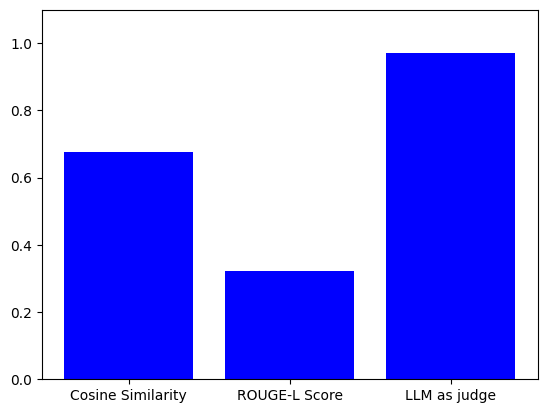

In [ ]:
import matplotlib.pyplot as plt

# Data
x_labels = ['Cosine Similarity', 'ROUGE-L Score', 'LLM as judge']
y_values = [0.6752, 0.3229, 0.971]

# Plotting
plt.bar(x_labels, y_values, color=['blue', 'blue', 'blue'])

# Adding labels and title
plt.xlabel('')
plt.ylabel('')
plt.ylim(0.0, 1.1)
plt.title('')

# Display the plot
plt.show()
